In [2]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from collections import OrderedDict

## Load data

In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [4]:
train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,year,credit_age
0,28000.0,36 months,6.49,858.05,6,2,10,1,92000.0,0,...,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0,2015,31
1,17600.0,60 months,19.89,465.22,2,3,0,2,44000.0,2,...,100.0,100.0,0.0,0.0,139633.0,133285.0,12600.0,127033.0,2015,9
2,12000.0,36 months,10.78,391.62,5,4,3,2,40000.0,0,...,90.5,20.0,0.0,0.0,59420.0,31915.0,21200.0,32820.0,2015,7
3,33600.0,36 months,10.78,1096.53,5,4,9,2,104000.0,1,...,96.8,33.3,0.0,0.0,92909.0,42952.0,33200.0,37909.0,2015,15
4,11550.0,60 months,16.59,284.51,3,2,5,2,38000.0,0,...,100.0,60.0,0.0,0.0,34105.0,10353.0,12300.0,16005.0,2015,4


In [5]:
# Drop state variable for now as it has 50 factors
train = train.drop(labels = 'addr_state', axis = 1)
test = test.drop(labels = 'addr_state', axis = 1)

In [6]:
# Convert factors to one hot encoding
convert_factors = train.select_dtypes(include=['object']).columns
train = pd.get_dummies(train, columns = convert_factors)
test = pd.get_dummies(test, columns = convert_factors)

In [7]:
# Remove columns which do not appear in test set
col_not_test = set()
for col in train.columns:
    if (col not in test.columns) and (col != 'loan_status'):
        col_not_test.add(col)

In [8]:
train = train.drop(columns= list(col_not_test))

In [9]:
# Extract the datasets
y_train= train['loan_status']
X_train = train.drop(columns=['loan_status'])
y_test= test['loan_status']
X_test = test.drop(columns=['loan_status'])

In [10]:
from sklearn import preprocessing

In [11]:
scaler = preprocessing.RobustScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Import Libraries
# Import models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb

# Utilities for building and selecting model
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics

In [39]:
# Cross validation of model
n_folds = 5 # 5 fold cross validation

def metric_cv(model,X, y, metric='AUC'):
    #X = X_train
    #y = y_train
    kf = KFold(n_folds, shuffle = True, random_state=42).get_n_splits(X)
    if metric == 'AUC':
        auc = cross_val_score(model,X,y,scoring='roc_auc',cv=kf)
        return auc
    else:
        print('Metric not recognized')
        return

### Base Models

In [14]:
# Logistic Regression
logisticregression = make_pipeline(preprocessing.RobustScaler(),LogisticRegression(C = 0.01, penalty='l2', verbose=1, solver='sag', n_jobs=-1))

In [15]:
scores = metric_cv(logisticregression, X_train,y_train)
print('Logistic Regression model scores, mean {0:.4f}, std {1:.4f}'.format(scores.mean(),scores.std()))

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 98 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 97 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 95 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.6min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 104 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 118 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.0min finished


Logistic Regression model scores, mean 0.5175, std 0.0058


In [16]:
# Fit model on full train set
logisticregression.fit(X_train,y_train)
# Predict on test set
pred_test = logisticregression.predict(X_test)
# Get AUC score
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)
print('Logistic Regression model scores on test set {0:.4f}'.format(metrics.auc(fpr, tpr)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 128 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.1min finished


Logistic Regression model scores on test set 0.5056


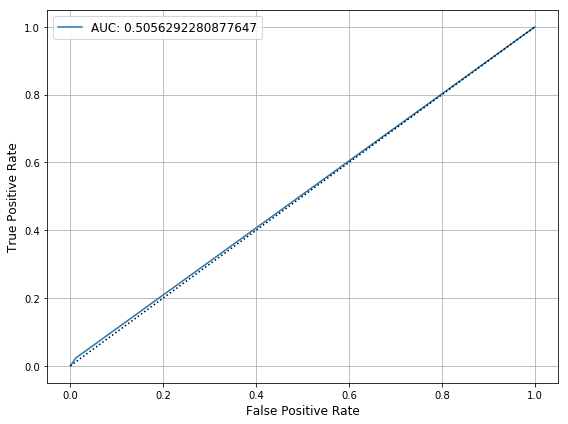

In [17]:
# ROC curve
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label='AUC: ' + str(metrics.auc(fpr, tpr)))
ax.plot(fpr, fpr, 'k:')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

The dataset is so imbalanced that the model actually prefers to classify all loans in the test set as good.We will have to explore more specialized methods like Over and Under Sampling in order to train the model

### Models using Over/Under Sampling Methods

In [18]:
from imblearn.over_sampling import SMOTE

In [21]:
#sm = SMOTE(random_state=12, ratio = 1.0)
#X_train_res, Y_train_res = sm.fit_sample(X_train, y_train)

In [28]:
from imblearn.over_sampling import RandomOverSampler

In [33]:
rm = RandomOverSampler(random_state=0)
X_train_res, Y_train_res = sm.fit_sample(X_train, y_train)

In [40]:
# Fit model on full train set
logisticregression.fit(X_train_res,Y_train_res)
# Predict on test set
pred_test = logisticregression.predict(X_test)
# Get AUC score
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)
print('Logistic Regression model scores on test set {0:.4f}'.format(metrics.auc(fpr, tpr)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 163 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.7min finished


Logistic Regression model scores on test set 0.5247
